In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import gc

# Read in chunks
chunk_size = 10000  # Adjust based on your memory capacity
chunks = []

for chunk in pd.read_csv('/content/drive/MyDrive/WWT data set/order_data.csv', chunksize=chunk_size):
    # Process each chunk as needed
    processed_chunk = chunk  # Apply your processing here
    chunks.append(processed_chunk)

# Combine chunks if needed
df = pd.concat(chunks, ignore_index=True)

# Clear memory
del chunks
gc.collect()


0

In [3]:
df.shape

(1414410, 8)

In [4]:
df['ORDER_CHANNEL_NAME'].value_counts()

,count
ORDER_CHANNEL_NAME,
Digital,1414410


In [5]:
df.head()

,CUSTOMER_ID,STORE_NUMBER,ORDER_CREATED_DATE,ORDER_ID,ORDERS,ORDER_CHANNEL_NAME,ORDER_SUBCHANNEL_NAME,ORDER_OCCASION_NAME
0,362204699,2156,2024-07-24,7247194287,"{""orders"": [{""item_details"": [{""item_name"": ""O...",Digital,WWT,ToGo
1,269612955,1419,2025-02-15,791214421,"{""orders"": [{""item_details"": [{""item_name"": ""R...",Digital,WWT,ToGo
2,585330633,2249,2025-02-15,7575285208,"{""orders"": [{""item_details"": [{""item_name"": ""2...",Digital,WWT,ToGo
3,950661333,2513,2024-03-29,4253875716,"{""orders"": [{""item_details"": [{""item_name"": ""O...",Digital,WWT,ToGo
4,434985772,1754,2024-04-08,7150407872,"{""orders"": [{""item_details"": [{""item_name"": ""O...",Digital,WWT,ToGo


In [6]:
df.isnull().sum()

,0
CUSTOMER_ID,0
STORE_NUMBER,0
ORDER_CREATED_DATE,0
ORDER_ID,0
ORDERS,0
ORDER_CHANNEL_NAME,0
ORDER_SUBCHANNEL_NAME,0
ORDER_OCCASION_NAME,0


In [9]:
import pandas as pd
import json
import numpy as np

def transform_order_data(df):
    """
    Transform the ORDERS JSON column into 13 structured columns:
    - item1 to item6: Item names
    - item1_price to item6_price: Item prices
    - avg_order_price: Average price per item in the order
    """

    def parse_and_transform_order(orders_json):
        """Extract and structure order data from JSON"""

        # Define non-food items to filter out
        non_food_keywords = [
            'Order Memo', 'Order Blankline', 'Plastic',
            'Not Paid', 'Paid', 'ASAP', 'Future'
        ]

        # Initialize result dictionary
        result = {}

        # Initialize item columns
        for i in range(1, 7):
            result[f'item{i}'] = None
            result[f'item{i}_price'] = 0.0
        result['avg_order_price'] = 0.0

        try:
            if pd.isna(orders_json):
                return result

            order_data = json.loads(orders_json)
            food_items = []

            # Extract food items
            for order in order_data.get('orders', []):
                for item in order.get('item_details', []):
                    item_name = item.get('item_name', '')

                    # Filter out non-food items
                    if not any(keyword in item_name for keyword in non_food_keywords):
                        if item.get('item_quantity', 0) > 0 and item_name.strip():
                            food_items.append({
                                'item_name': item_name.strip(),
                                'item_price': float(item.get('item_price', 0)),
                                'item_quantity': int(item.get('item_quantity', 1))
                            })

            # Fill item columns (up to 6 items)
            for i, item in enumerate(food_items[:6], 1):
                result[f'item{i}'] = item['item_name']
                result[f'item{i}_price'] = item['item_price']

            # Calculate average order price
            if food_items:
                total_value = sum(item['item_price'] * item['item_quantity'] for item in food_items)
                total_quantity = sum(item['item_quantity'] for item in food_items)

                if total_quantity > 0:
                    result['avg_order_price'] = round(total_value / total_quantity, 2)

            return result

        except (json.JSONDecodeError, KeyError, TypeError, ValueError) as e:
            print(f"Error parsing order: {e}")
            return result

    # Apply the transformation function to the 'ORDERS' column
    transformed_orders = df['ORDERS'].apply(parse_and_transform_order)

    # Create new columns from the transformed data
    transformed_df = pd.json_normalize(transformed_orders)

    # Concatenate the new columns with the original DataFrame
    df = pd.concat([df, transformed_df], axis=1)

    return df


def analyze_transformation_results(df):
    """Analyze the results of the transformation"""

    print("\n=== TRANSFORMATION ANALYSIS ===")

    # Count non-null items per column
    item_columns = [f'item{i}' for i in range(1, 7)]
    price_columns = [f'item{i}_price' for i in range(1, 7)]

    print("\nItem distribution across columns:")
    for col in item_columns:
        non_null_count = df[col].notna().sum()
        print(f"{col}: {non_null_count} orders ({non_null_count/len(df)*100:.1f}%)")

    # Average order statistics
    print(f"\nAverage order price statistics:")
    print(f"Mean avg_order_price: ${df['avg_order_price'].mean():.2f}")
    print(f"Median avg_order_price: ${df['avg_order_price'].median():.2f}")
    print(f"Max avg_order_price: ${df['avg_order_price'].max():.2f}")
    print(f"Min avg_order_price: ${df['avg_order_price'].min():.2f}")

    # Most popular items
    print(f"\nTop 10 most popular items:")
    all_items = []
    for col in item_columns:
        all_items.extend(df[col].dropna().tolist())

    from collections import Counter
    item_counts = Counter(all_items)
    for item, count in item_counts.most_common(10):
        print(f"{item}: {count}")

    # Orders with maximum items (6)
    orders_with_6_items = df[df['item6'].notna()].shape[0]
    print(f"\nOrders with 6 items: {orders_with_6_items} ({orders_with_6_items/len(df)*100:.1f}%)")

    return df

# Apply the transformation to your data
print("Transforming data...")

# Transform the data
transformed_data = transform_order_data(df)

print(f"\nTransformed data shape: {transformed_data.shape}")
print(f"New columns: {list(transformed_data.columns)}")

# Analyze results
final_data = analyze_transformation_results(transformed_data)

# Display sample of transformed data
print("\n=== SAMPLE TRANSFORMED DATA ===")
sample_cols = ['CUSTOMER_ID', 'ORDER_ID'] + [f'item{i}' for i in range(1, 4)] + [f'item{i}_price' for i in range(1, 4)] + ['avg_order_price']
display(transformed_data[sample_cols].head(10))

Transforming data...

Transformed data shape: (1414410, 21)
New columns: ['CUSTOMER_ID', 'STORE_NUMBER', 'ORDER_CREATED_DATE', 'ORDER_ID', 'ORDERS', 'ORDER_CHANNEL_NAME', 'ORDER_SUBCHANNEL_NAME', 'ORDER_OCCASION_NAME', 'item1', 'item1_price', 'item2', 'item2_price', 'item3', 'item3_price', 'item4', 'item4_price', 'item5', 'item5_price', 'item6', 'item6_price', 'avg_order_price']

=== TRANSFORMATION ANALYSIS ===

Item distribution across columns:
item1: 1414410 orders (100.0%)
item2: 813990 orders (57.5%)
item3: 373060 orders (26.4%)
item4: 143044 orders (10.1%)
item5: 49626 orders (3.5%)
item6: 16126 orders (1.1%)

Average order price statistics:
Mean avg_order_price: $17.27
Median avg_order_price: $13.39
Max avg_order_price: $3664.58
Min avg_order_price: $0.00

Top 10 most popular items:
Ranch Dip - Regular: 302407
20pc Spicy Feast Deal: 267911
10 pc Grilled Wings Combo: 166534
6 pc Grilled Wings Combo: 117790
8 pc Grilled Wings Combo: 117503
Regular Buffalo Fries: 99763
2 pc Crispy S

,CUSTOMER_ID,ORDER_ID,item1,item2,item3,item1_price,item2_price,item3_price,avg_order_price
0,362204699,7247194287,10 pc Grilled Wings Combo,8 pc Grilled Wings Combo,8 pc Spicy Wings Combo,15.29,13.29,10.99,13.19
1,269612955,791214421,Ranch Dip - Regular,50 pc Grilled Wings,Regular Buffalo Fries,1.59,65.49,3.49,23.52
2,585330633,7575285208,20pc Spicy Feast Deal,None,None,16.99,0.00,0.00,16.99
3,950661333,4253875716,20 pc Grilled Wings,Ranch Dip - Regular,None,26.59,1.49,0.00,14.04
4,434985772,7150407872,6 pc Grilled Wings Combo,8 pc Grilled Wings Combo,None,11.29,13.29,0.00,12.29
5,126084616,3060989630,10 pc Grilled Wings Combo,None,None,37.98,0.00,0.00,37.98
6,426992703,1655782790,10 pc Grilled Wings,Ranch Dip - Regular,None,12.29,1.49,0.00,6.89
7,772568272,4015163280,20pc Spicy Feast Deal,None,None,16.99,0.00,0.00,16.99
8,715522716,3057756219,Fried Corn - Regular,20pc Spicy Feast Deal,Regular Buffalo Fries,3.99,16.99,3.49,7.31
9,591908874,4349588916,Ranch Dip - Regular,20 pc Grilled Wings,Veggie Sticks Spicy,1.49,23.99,1.99,9.16



Saving transformed data...
Transformation complete! Data saved as 'transformed_order_data.csv'


In [11]:
transformed_data.drop(columns=['ORDERS'], inplace=True)

In [12]:
transformed_data.head()

,CUSTOMER_ID,STORE_NUMBER,ORDER_CREATED_DATE,ORDER_ID,ORDER_CHANNEL_NAME,ORDER_SUBCHANNEL_NAME,ORDER_OCCASION_NAME,item1,item1_price,item2,item2_price,item3,item3_price,item4,item4_price,item5,item5_price,item6,item6_price,avg_order_price
0,362204699,2156,2024-07-24,7247194287,Digital,WWT,ToGo,10 pc Grilled Wings Combo,15.29,8 pc Grilled Wings Combo,13.29,8 pc Spicy Wings Combo,10.99,None,0.0,None,0.0,None,0.0,13.19
1,269612955,1419,2025-02-15,791214421,Digital,WWT,ToGo,Ranch Dip - Regular,1.59,50 pc Grilled Wings,65.49,Regular Buffalo Fries,3.49,None,0.0,None,0.0,None,0.0,23.52
2,585330633,2249,2025-02-15,7575285208,Digital,WWT,ToGo,20pc Spicy Feast Deal,16.99,None,0.00,None,0.00,None,0.0,None,0.0,None,0.0,16.99
3,950661333,2513,2024-03-29,4253875716,Digital,WWT,ToGo,20 pc Grilled Wings,26.59,Ranch Dip - Regular,1.49,None,0.00,None,0.0,None,0.0,None,0.0,14.04
4,434985772,1754,2024-04-08,7150407872,Digital,WWT,ToGo,6 pc Grilled Wings Combo,11.29,8 pc Grilled Wings Combo,13.29,None,0.00,None,0.0,None,0.0,None,0.0,12.29


In [13]:
# Save the transformed data
print("\nSaving transformed data...")
transformed_data.to_csv('transformed_order_data.csv', index=False)
print("Transformation complete! Data saved as 'transformed_order_data.csv'")


Saving transformed data...
Transformation complete! Data saved as 'transformed_order_data.csv'


In [15]:
print(transformed_data['CUSTOMER_ID'].unique().size)

563346


In [16]:
df_cf = pd.read_csv('/content/drive/MyDrive/WWT data set/customer_data.csv')

In [17]:
print(df_cf['CUSTOMER_ID'].unique().size)

563346


In [19]:
# Inner join will keep only matching CUSTOMER_IDs
common_df = pd.merge(transformed_data[['CUSTOMER_ID']], df_cf[['CUSTOMER_ID']],
                     on='CUSTOMER_ID', how='inner')

# Get unique count (in case there are duplicates)
common_count = common_df['CUSTOMER_ID'].nunique()

print(f"Number of common CUSTOMER_IDs: {common_count}")

Number of common CUSTOMER_IDs: 563346


In [20]:
df_final1= transformed_data.merge(
    df_cf[['CUSTOMER_ID', 'CUSTOMER_TYPE']],
    on='CUSTOMER_ID',
    how='left'
)

In [21]:
df_final1.shape

(1414410, 21)

In [23]:
df_final1.to_csv('combine_order_data.csv', index=False)

In [30]:
df_final1.head()

,CUSTOMER_ID,STORE_NUMBER,ORDER_CREATED_DATE,ORDER_ID,ORDER_CHANNEL_NAME,ORDER_SUBCHANNEL_NAME,ORDER_OCCASION_NAME,item1,item1_price,item2,...,item3,item3_price,item4,item4_price,item5,item5_price,item6,item6_price,avg_order_price,CUSTOMER_TYPE
0,362204699,2156,2024-07-24,7247194287,Digital,WWT,ToGo,10 pc Grilled Wings Combo,15.29,8 pc Grilled Wings Combo,...,8 pc Spicy Wings Combo,10.99,None,0.0,None,0.0,None,0.0,13.19,Registered
1,269612955,1419,2025-02-15,791214421,Digital,WWT,ToGo,Ranch Dip - Regular,1.59,50 pc Grilled Wings,...,Regular Buffalo Fries,3.49,None,0.0,None,0.0,None,0.0,23.52,Registered
2,585330633,2249,2025-02-15,7575285208,Digital,WWT,ToGo,20pc Spicy Feast Deal,16.99,None,...,None,0.00,None,0.0,None,0.0,None,0.0,16.99,Guest
3,950661333,2513,2024-03-29,4253875716,Digital,WWT,ToGo,20 pc Grilled Wings,26.59,Ranch Dip - Regular,...,None,0.00,None,0.0,None,0.0,None,0.0,14.04,Registered
4,434985772,1754,2024-04-08,7150407872,Digital,WWT,ToGo,6 pc Grilled Wings Combo,11.29,8 pc Grilled Wings Combo,...,None,0.00,None,0.0,None,0.0,None,0.0,12.29,Guest


In [32]:
# Investigate price variations for same items
price_analysis = df_final1.groupby('item1').agg({
    'item1_price': ['min', 'max', 'mean', 'count', 'std']
}).round(2)

# Find items with high price variance
high_variance_items = price_analysis[
    price_analysis[('item1_price', 'std')] > 5.0  # Adjust threshold
].sort_values(('item1_price', 'std'), ascending=False)

print("Items with highest price variance:")
print(high_variance_items.head(10))

Items with highest price variance:
                            item1_price                               
                                    min      max    mean count     std
item1                                                                 
100 pc Family Mixed Wings          0.00  3535.74  171.04   751  184.77
100 pc Grilled Wings              93.49  1781.43  161.68   285  153.49
100 pc Family Spicy Wings          0.00  2051.82  163.47   433  145.22
100 pc Family Grilled Wings        0.00  2209.83  165.81  1432  128.49
75 pc Family Grilled Wings         0.00  3219.72  122.52  2568  120.89
75 pc Family Mixed Wings           0.00  1954.83  118.00  1403   83.45
100 pc Mixed Wings                 0.00   451.96  135.01    94   66.44
75 pc Family Spicy Wings           0.00  1322.28  103.35   725   59.56
75 pc Spicy Wings                  0.00   503.94   83.90   111   57.00
100 pc Spicy Wings                 0.00   320.00  119.24    94   55.44


In [53]:
import pandas as pd
import numpy as np

def detect_price_outliers(df_input, item_col, price_col):
    outliers = []

    for item in df_input[item_col].unique():
        if pd.notna(item) and item != '':
            item_prices = df_input[df_input[item_col] == item][price_col]

            # Need at least 4 data points for meaningful quartiles
            if len(item_prices) < 4:
                continue

            # IQR method
            Q1 = item_prices.quantile(0.25)
            Q3 = item_prices.quantile(0.75)
            IQR = Q3 - Q1

            # Skip if IQR is 0 (all prices are the same)
            if IQR == 0:
                continue

            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Flag outliers
            item_outliers = df_input[
                (df_input[item_col] == item) &
                ((df_input[price_col] < lower_bound) | (df_input[price_col] > upper_bound))
            ]

            if len(item_outliers) > 0:
                outliers.append(item_outliers)

    return pd.concat(outliers, ignore_index=True) if outliers else pd.DataFrame()

# Apply to all item columns in df_final1
all_outliers = []

for i in range(1, 7):  # item1 through item6
    item_col = f'item{i}'
    price_col = f'item{i}_price'

    # Check if columns exist in your dataset
    if item_col in df_final1.columns and price_col in df_final1.columns:
        print(f"\nAnalyzing {item_col}...")
        outliers = detect_price_outliers(df_final1, item_col, price_col)

        if len(outliers) > 0:
            # Add a column to track which item column the outlier came from
            outliers[f'outlier_source'] = item_col
            all_outliers.append(outliers)
            print(f"Found {len(outliers)} price outliers in {item_col}")
        else:
            print(f"No outliers found in {item_col}")

# Combine all outliers
if all_outliers:
    all_outliers_combined = pd.concat(all_outliers, ignore_index=True)
    print(f"\n=== SUMMARY ===")
    print(f"Total price outliers found: {len(all_outliers_combined):,}")

    # Show breakdown by item column
    print("\nOutliers by item position:")
    print(all_outliers_combined['outlier_source'].value_counts())

else:
    all_outliers_combined = pd.DataFrame()
    print("No price outliers found in any item columns")

# Optional: Show sample of outliers for review
if len(all_outliers_combined) > 0:
    print(f"\nSample of detected outliers:")
    sample_cols = ['ORDER_ID', 'CUSTOMER_ID', 'outlier_source'] + \
                  [col for col in ['item1', 'item1_price', 'item2', 'item2_price'] if col in all_outliers_combined.columns]
    print(all_outliers_combined[sample_cols].head(10).to_string())


Analyzing item1...
Found 164354 price outliers in item1

Analyzing item2...
Found 89582 price outliers in item2

Analyzing item3...
Found 32823 price outliers in item3

Analyzing item4...
Found 13070 price outliers in item4

Analyzing item5...
Found 5106 price outliers in item5

Analyzing item6...
Found 1924 price outliers in item6

=== SUMMARY ===
Total price outliers found: 306,859

Outliers by item position:
outlier_source
item1    164354
item2     89582
item3     32823
item4     13070
item5      5106
item6      1924
Name: count, dtype: int64

Sample of detected outliers:
     ORDER_ID  CUSTOMER_ID outlier_source                      item1  item1_price                     item2  item2_price
0  3060989630    126084616          item1  10 pc Grilled Wings Combo        37.98                      None         0.00
1  3837278590     34075893          item1  10 pc Grilled Wings Combo        28.98                      None         0.00
2  7665559584    956505838          item1  10 pc Grill

In [55]:
# Apply corrections to all item columns
df_corrected_all = df_final1.copy() # Start with a copy of the data before any corrections

for i in range(1, 7):
    item_col = f'item{i}'
    price_col = f'item{i}_price'

    if item_col in df_corrected_all.columns and price_col in df_corrected_all.columns:
        print(f"Correcting outliers in {item_col}...")
        # Apply quick corrections
        df_corrected_all, quick_fixes = quick_corrections(df_corrected_all)
        # Apply statistical corrections
        df_corrected_all, statistical_fixes = statistical_corrections(df_corrected_all)
        print(f"Applied {quick_fixes + statistical_fixes} corrections to {item_col}")
    else:
        print(f"Columns {item_col} or {price_col} not found.")

# Update df_final1 with the fully corrected data if needed, or save df_corrected_all
# For now, let's keep the fully corrected data in df_corrected_all
# df_final1 = df_corrected_all.copy()

Correcting outliers in item1...
Applied 133205 corrections to item1
Correcting outliers in item2...
Applied 75539 corrections to item2
Correcting outliers in item3...
Applied 519 corrections to item3
Correcting outliers in item4...
Applied 167 corrections to item4
Correcting outliers in item5...
Applied 87 corrections to item5
Correcting outliers in item6...
Applied 0 corrections to item6


In [56]:
# Compare outlier counts
print("=== OUTLIER REDUCTION SUMMARY ===")
print(f"Original outliers: {len(outliers_detected):,}")
print(f"Remaining outliers: {len(outliers_after):,}")
print(f"Outliers removed: {len(outliers_detected) - len(outliers_after):,}")
print(f"Reduction percentage: {((len(outliers_detected) - len(outliers_after))/len(outliers_detected)*100):.1f}%")

=== OUTLIER REDUCTION SUMMARY ===
Original outliers: 165,934
Remaining outliers: 103,887
Outliers removed: 62,047
Reduction percentage: 37.4%


In [60]:
df_final_clean = df_corrected_all.copy()
df_final_clean.to_csv('hackathon_ready_dataset.csv', index=False)

In [62]:
df_final_clean.shape

(1414410, 21)

In [64]:
# Basic customer repeat analysis
customer_order_counts = df_final_clean.groupby('CUSTOMER_ID').agg({
    'ORDER_ID': 'nunique',
    'ORDER_CREATED_DATE': ['min', 'max'],
    'avg_order_price': 'mean'
}).round(2)

customer_order_counts.columns = ['total_orders', 'first_order', 'last_order', 'avg_order_value']

print("=== CUSTOMER REPEAT BEHAVIOR ANALYSIS ===")
print(f"Total unique customers: {df_final_clean['CUSTOMER_ID'].nunique():,}")
print(f"Total orders: {df_final_clean['ORDER_ID'].nunique():,}")

# Customer segmentation by order frequency
repeat_analysis = customer_order_counts['total_orders'].value_counts().sort_index()
print(f"\n📊 Customer Order Frequency Distribution:")
print(repeat_analysis.head(10))

=== CUSTOMER REPEAT BEHAVIOR ANALYSIS ===
Total unique customers: 563,346
Total orders: 1,414,410

📊 Customer Order Frequency Distribution:
total_orders
1     332734
2      90035
3      43854
4      25901
5      17014
6      11934
7       8469
8       6507
9       4969
10      3904
Name: count, dtype: int64


In [65]:
# Categorize customers by behavior
def categorize_customer(order_count):
    if order_count == 1:
        return 'One-time'
    elif order_count <= 3:
        return 'Occasional (2-3 orders)'
    elif order_count <= 10:
        return 'Regular (4-10 orders)'
    else:
        return 'Loyal (10+ orders)'

customer_order_counts['customer_segment'] = customer_order_counts['total_orders'].apply(categorize_customer)

# Segment distribution
segment_analysis = customer_order_counts['customer_segment'].value_counts()
segment_percentages = (segment_analysis / len(customer_order_counts) * 100).round(1)

print("\n🎯 Customer Segmentation:")
for segment, count in segment_analysis.items():
    pct = segment_percentages[segment]
    print(f"  {segment}: {count:,} customers ({pct}%)")

# Revenue contribution by segment
revenue_by_segment = customer_order_counts.groupby('customer_segment').agg({
    'total_orders': 'sum',
    'avg_order_value': 'mean'
}).round(2)

print(f"\n💰 Revenue Analysis by Segment:")
print(revenue_by_segment)


🎯 Customer Segmentation:
  One-time: 332,734 customers (59.1%)
  Occasional (2-3 orders): 133,889 customers (23.8%)
  Regular (4-10 orders): 78,698 customers (14.0%)
  Loyal (10+ orders): 18,025 customers (3.2%)

💰 Revenue Analysis by Segment:
                         total_orders  avg_order_value
customer_segment                                      
Loyal (10+ orders)             314666            15.21
Occasional (2-3 orders)        311632            17.94
One-time                       332734            19.62
Regular (4-10 orders)          455378            16.90


In [66]:
# Calculate customer lifetime and frequency
customer_order_counts['days_between_first_last'] = (
    pd.to_datetime(customer_order_counts['last_order']) -
    pd.to_datetime(customer_order_counts['first_order'])
).dt.days

customer_order_counts['avg_days_between_orders'] = (
    customer_order_counts['days_between_first_last'] /
    (customer_order_counts['total_orders'] - 1)
).fillna(0)

# Repeat customers detailed analysis
repeat_customers = customer_order_counts[customer_order_counts['total_orders'] > 1]

print(f"\n🔄 Repeat Customer Deep Dive:")
print(f"Repeat customers: {len(repeat_customers):,} ({len(repeat_customers)/len(customer_order_counts)*100:.1f}%)")
print(f"Average orders per repeat customer: {repeat_customers['total_orders'].mean():.1f}")
print(f"Average days between orders: {repeat_customers['avg_days_between_orders'].mean():.0f} days")
print(f"Max orders by single customer: {customer_order_counts['total_orders'].max()}")


🔄 Repeat Customer Deep Dive:
Repeat customers: 230,612 (40.9%)
Average orders per repeat customer: 4.7
Average days between orders: 75 days
Max orders by single customer: 2802


In [67]:
# Analyze by registered vs guest
customer_type_analysis = df_final_clean.groupby(['CUSTOMER_ID', 'CUSTOMER_TYPE']).size().reset_index(name='order_count')
customer_type_summary = customer_type_analysis.groupby('CUSTOMER_TYPE').agg({
    'CUSTOMER_ID': 'count',
    'order_count': 'mean'
}).round(2)

customer_type_summary.columns = ['total_customers', 'avg_orders_per_customer']

print(f"\n👤 Customer Type Analysis:")
print(customer_type_summary)

# Repeat rate by customer type
repeat_rate_by_type = customer_type_analysis[customer_type_analysis['order_count'] > 1].groupby('CUSTOMER_TYPE').size()
total_by_type = customer_type_analysis.groupby('CUSTOMER_TYPE').size()
repeat_rates = (repeat_rate_by_type / total_by_type * 100).round(1)

print(f"\n🔁 Repeat Rate by Customer Type:")
for customer_type, rate in repeat_rates.items():
    print(f"  {customer_type}: {rate}%")


👤 Customer Type Analysis:
                 total_customers  avg_orders_per_customer
CUSTOMER_TYPE                                            
Deleted Account              348                     2.39
Guest                     155132                     1.75
Online                         2                     1.00
Registered                406653                     2.80
eClub                       1184                     1.61

🔁 Repeat Rate by Customer Type:
  Deleted Account: 45.1%
  Guest: 26.9%
  Online: nan%
  Registered: 46.3%
  eClub: 25.0%


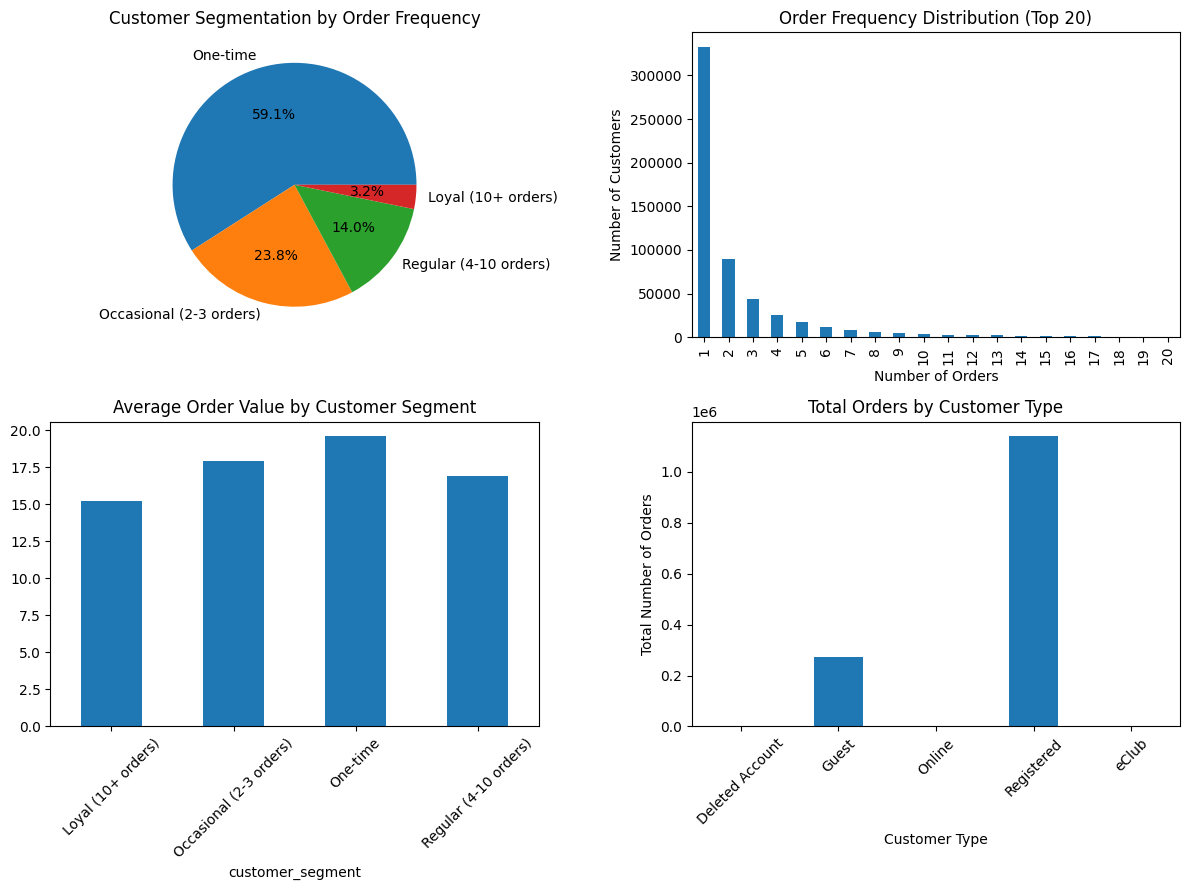

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting
fig, axes = plt.subplots(2, 2, figsize=(12,9))

# 1. Customer segments pie chart
axes[0,0].pie(segment_analysis.values, labels=segment_analysis.index, autopct='%1.1f%%')
axes[0,0].set_title('Customer Segmentation by Order Frequency')

# 2. Order frequency distribution (top 20)
repeat_analysis.head(20).plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Order Frequency Distribution (Top 20)')
axes[0,1].set_xlabel('Number of Orders')
axes[0,1].set_ylabel('Number of Customers')

# 3. AOV by customer segment
segment_aov = customer_order_counts.groupby('customer_segment')['avg_order_value'].mean()
segment_aov.plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Average Order Value by Customer Segment')
axes[1,0].tick_params(axis='x', rotation=45)

# 4. Total Orders by Customer Type
orders_by_customer_type = df_final_clean.groupby('CUSTOMER_TYPE')['ORDER_ID'].nunique()
orders_by_customer_type.plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Total Orders by Customer Type')
axes[1,1].set_xlabel('Customer Type')
axes[1,1].set_ylabel('Total Number of Orders')
axes[1,1].tick_params(axis='x', rotation=45)


plt.tight_layout()
plt.show()

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

# Analyze item distribution across all positions
item_columns = ['item1', 'item2', 'item3', 'item4', 'item5', 'item6']

# Overall item popularity (combining all positions)
all_items = []
for col in item_columns:
    items = df_final_clean[col].dropna()
    all_items.extend(items.tolist())

item_popularity = Counter(all_items)

print("=== TOP 20 MOST POPULAR ITEMS (ALL POSITIONS) ===")
for item, count in item_popularity.most_common(20):
    print(f"{item}: {count} orders ({count/len(df_final_clean)*100:.1f}%)")

=== TOP 20 MOST POPULAR ITEMS (ALL POSITIONS) ===
Ranch Dip - Regular: 302407 orders (21.4%)
20pc Spicy Feast Deal: 267911 orders (18.9%)
10 pc Grilled Wings Combo: 166534 orders (11.8%)
6 pc Grilled Wings Combo: 117790 orders (8.3%)
8 pc Grilled Wings Combo: 117503 orders (8.3%)
Regular Buffalo Fries: 99763 orders (7.1%)
2 pc Crispy Strips: 83953 orders (5.9%)
Ranch Dip - Large: 80271 orders (5.7%)
6 pc Spicy Wings Combo: 72129 orders (5.1%)
10 pc Grilled Wings: 66673 orders (4.7%)
Large Buffalo Fries: 59745 orders (4.2%)
8 pc Spicy Wings Combo: 59206 orders (4.2%)
10 pc Spicy Wings: 58782 orders (4.2%)
Fried Corn - Regular: 58360 orders (4.1%)
Chicken Sub Combo: 58081 orders (4.1%)
10 pc Spicy Wings Combo: 57304 orders (4.1%)
Flavor Platter: 55639 orders (3.9%)
3 pc Crispy Strips Combo: 54400 orders (3.8%)
Chicken Sub: 45093 orders (3.2%)
15 pc Grilled Wings Combo: 43433 orders (3.1%)


In [79]:
# Analyze which items appear in which positions
position_analysis = {}

for col in item_columns:
    position_items = df_final_clean[col].value_counts().head(10)
    position_analysis[col] = position_items

    print(f"\n=== TOP 10 ITEMS IN {col.upper()} ===")
    for item, count in position_items.items():
        print(f"{item}: {count} ({count/df_final_clean[col].notna().sum()*100:.1f}%)")


=== TOP 10 ITEMS IN ITEM1 ===
20pc Spicy Feast Deal: 194540 (13.8%)
Ranch Dip - Regular: 110207 (7.8%)
10 pc Grilled Wings Combo: 97519 (6.9%)
6 pc Grilled Wings Combo: 70772 (5.0%)
8 pc Grilled Wings Combo: 70533 (5.0%)
6 pc Spicy Wings Combo: 42889 (3.0%)
Flavor Platter: 38392 (2.7%)
8 pc Spicy Wings Combo: 35089 (2.5%)
Chicken Sub Combo: 34443 (2.4%)
Regular Buffalo Fries: 33798 (2.4%)

=== TOP 10 ITEMS IN ITEM2 ===
Ranch Dip - Regular: 110807 (13.6%)
20pc Spicy Feast Deal: 52585 (6.5%)
10 pc Grilled Wings Combo: 45359 (5.6%)
Regular Buffalo Fries: 33233 (4.1%)
6 pc Grilled Wings Combo: 30668 (3.8%)
8 pc Grilled Wings Combo: 30537 (3.8%)
2 pc Crispy Strips: 30360 (3.7%)
Ranch Dip - Large: 27619 (3.4%)
10 pc Grilled Wings: 20627 (2.5%)
Fried Corn - Regular: 19671 (2.4%)

=== TOP 10 ITEMS IN ITEM3 ===
Ranch Dip - Regular: 54707 (14.7%)
Regular Buffalo Fries: 20621 (5.5%)
10 pc Grilled Wings Combo: 16515 (4.4%)
Ranch Dip - Large: 15300 (4.1%)
20pc Spicy Feast Deal: 15143 (4.1%)
2 pc C

In [81]:
# Calculate basket sizes
df_final_clean['basket_size'] = df_final_clean[item_columns].notna().sum(axis=1)

basket_analysis = {
    'avg_basket_size': df_final_clean['basket_size'].mean(),
    'median_basket_size': df_final_clean['basket_size'].median(),
    'basket_size_distribution': df_final_clean['basket_size'].value_counts().sort_index(),
    'single_item_orders': (df_final_clean['basket_size'] == 1).sum(),
    'multi_item_orders': (df_final_clean['basket_size'] > 1).sum()
}

print("=== BASKET SIZE ANALYSIS ===")
print(f"Average basket size: {basket_analysis['avg_basket_size']:.2f} items")
print(f"Median basket size: {basket_analysis['median_basket_size']:.1f} items")
print(f"Single-item orders: {basket_analysis['single_item_orders']} ({basket_analysis['single_item_orders']/len(df_final_clean)*100:.1f}%)")
print(f"Multi-item orders: {basket_analysis['multi_item_orders']} ({basket_analysis['multi_item_orders']/len(df_final_clean)*100:.1f}%)")

print(f"\nBasket Size Distribution:")
for size, count in basket_analysis['basket_size_distribution'].items():
    print(f"  {size} items: {count} orders ({count/len(df_final_clean)*100:.1f}%)")

=== BASKET SIZE ANALYSIS ===
Average basket size: 1.99 items
Median basket size: 2.0 items
Single-item orders: 600420 (42.5%)
Multi-item orders: 813990 (57.5%)

Basket Size Distribution:
  1 items: 600420 orders (42.5%)
  2 items: 440930 orders (31.2%)
  3 items: 230016 orders (16.3%)
  4 items: 93418 orders (6.6%)
  5 items: 33500 orders (2.4%)
  6 items: 16126 orders (1.1%)


In [83]:
# Categorize items by type
def categorize_item(item_name):
    if pd.isna(item_name):
        return 'Unknown'

    item_lower = str(item_name).lower()

    if 'wings' in item_lower and 'combo' in item_lower:
        return 'Wing Combos'
    elif 'wings' in item_lower:
        return 'Wings Only'
    elif 'strips' in item_lower and 'combo' in item_lower:
        return 'Strip Combos'
    elif 'strips' in item_lower:
        return 'Strips Only'
    elif 'dip' in item_lower:
        return 'Dips & Sauces'
    elif any(word in item_lower for word in ['fries', 'corn', 'veggie']):
        return 'Sides'
    elif any(word in item_lower for word in ['soda', 'punch', 'oz']):
        return 'Beverages'
    elif 'sub' in item_lower:
        return 'Sandwiches'
    elif any(word in item_lower for word in ['feast', 'deal', 'bundle', 'platter']):
        return 'Value Deals'
    else:
        return 'Other'

# Apply categorization to all items
all_items_with_categories = []
for col in item_columns:
    items = df_final_clean[col].dropna()
    for item in items:
        all_items_with_categories.append({
            'item': item,
            'category': categorize_item(item),
            'position': col
        })

category_df = pd.DataFrame(all_items_with_categories)
category_analysis = category_df['category'].value_counts()

print("=== ITEM CATEGORY DISTRIBUTION ===")
for category, count in category_analysis.items():
    print(f"{category}: {count} ({count/len(category_df)*100:.1f}%)")

=== ITEM CATEGORY DISTRIBUTION ===
Wing Combos: 680335 (24.2%)
Dips & Sauces: 507432 (18.1%)
Wings Only: 496011 (17.7%)
Sides: 340657 (12.1%)
Value Deals: 333842 (11.9%)
Strips Only: 147300 (5.2%)
Sandwiches: 103290 (3.7%)
Strip Combos: 98751 (3.5%)
Other: 53242 (1.9%)
Beverages: 49396 (1.8%)


In [85]:
# Analyze category combinations in multi-item orders
multi_item_orders = df_final_clean[df_final_clean['basket_size'] > 1].copy()

combination_patterns = []
for _, row in multi_item_orders.iterrows():
    order_categories = []
    for col in item_columns:
        if pd.notna(row[col]):
            category = categorize_item(row[col])
            order_categories.append(category)

    # Count unique category combinations
    unique_categories = list(set(order_categories))
    if len(unique_categories) > 1:
        combination_patterns.append(tuple(sorted(unique_categories)))

combination_analysis = Counter(combination_patterns)

print("=== TOP CATEGORY COMBINATIONS ===")
for combo, count in combination_analysis.most_common(10):
    print(f"{' + '.join(combo)}: {count} orders")

=== TOP CATEGORY COMBINATIONS ===
Dips & Sauces + Wing Combos: 102322 orders
Dips & Sauces + Wings Only: 68249 orders
Dips & Sauces + Sides + Wings Only: 63973 orders
Sides + Wings Only: 31092 orders
Sides + Value Deals: 27377 orders
Sides + Wing Combos: 22913 orders
Dips & Sauces + Value Deals: 20398 orders
Dips & Sauces + Sides + Wing Combos: 19028 orders
Dips & Sauces + Wing Combos + Wings Only: 17692 orders
Wing Combos + Wings Only: 17561 orders


1. Dips & Sauces Are THE Universal Add-On 🎯
Appears in 6 out of 10 top combinations

102,322 orders with

In [87]:
# Analyze pricing patterns by position
price_columns = [f'{col}_price' for col in item_columns]

position_price_analysis = {}
for i, col in enumerate(item_columns):
    price_col = f'{col}_price'
    if price_col in df_final_clean.columns:
        valid_prices = df_final_clean[df_final_clean[col].notna()][price_col]
        position_price_analysis[col] = {
            'avg_price': valid_prices.mean(),
            'median_price': valid_prices.median(),
            'min_price': valid_prices.min(),
            'max_price': valid_prices.max(),
            'std_price': valid_prices.std()
        }

print("=== PRICE ANALYSIS BY POSITION ===")
for position, stats in position_price_analysis.items():
    print(f"\n{position.upper()}:")
    print(f"  Average: ${stats['avg_price']:.2f}")
    print(f"  Median: ${stats['median_price']:.2f}")
    print(f"  Range: ${stats['min_price']:.2f} - ${stats['max_price']:.2f}")
    print(f"  Std Dev: ${stats['std_price']:.2f}")

=== PRICE ANALYSIS BY POSITION ===

ITEM1:
  Average: $15.28
  Median: $13.79
  Range: $0.00 - $169.79
  Std Dev: $14.15

ITEM2:
  Average: $12.46
  Median: $8.99
  Range: $0.00 - $2124.66
  Std Dev: $16.07

ITEM3:
  Average: $10.72
  Median: $5.89
  Range: $0.00 - $2249.75
  Std Dev: $14.38

ITEM4:
  Average: $10.04
  Median: $5.29
  Range: $0.00 - $2989.77
  Std Dev: $15.40

ITEM5:
  Average: $9.72
  Median: $5.17
  Range: $0.00 - $516.35
  Std Dev: $12.55

ITEM6:
  Average: $9.62
  Median: $5.19
  Range: $0.00 - $398.23
  Std Dev: $12.24


In [89]:
# Analyze item preferences by customer type
customer_item_analysis = {}

for customer_type in df_final_clean['CUSTOMER_TYPE'].unique():
    if pd.notna(customer_type):
        customer_orders = df_final_clean[df_final_clean['CUSTOMER_TYPE'] == customer_type]

        # Get all items for this customer type
        customer_items = []
        for col in item_columns:
            items = customer_orders[col].dropna()
            customer_items.extend(items.tolist())

        customer_item_analysis[customer_type] = Counter(customer_items)

print("=== TOP 5 ITEMS BY CUSTOMER TYPE ===")
for customer_type, item_counter in customer_item_analysis.items():
    print(f"\n{customer_type} Customers:")
    for item, count in item_counter.most_common(5):
        print(f"  {item}: {count} orders")

=== TOP 5 ITEMS BY CUSTOMER TYPE ===

Registered Customers:
  Ranch Dip - Regular: 249439 orders
  20pc Spicy Feast Deal: 217301 orders
  10 pc Grilled Wings Combo: 136695 orders
  6 pc Grilled Wings Combo: 96827 orders
  8 pc Grilled Wings Combo: 96227 orders

Guest Customers:
  Ranch Dip - Regular: 52464 orders
  20pc Spicy Feast Deal: 50130 orders
  10 pc Grilled Wings Combo: 29524 orders
  8 pc Grilled Wings Combo: 21071 orders
  6 pc Grilled Wings Combo: 20720 orders

Deleted Account Customers:
  Ranch Dip - Regular: 173 orders
  20pc Spicy Feast Deal: 159 orders
  10 pc Grilled Wings Combo: 100 orders
  6 pc Grilled Wings Combo: 98 orders
  Regular Buffalo Fries: 83 orders

eClub Customers:
  20pc Spicy Feast Deal: 318 orders
  Ranch Dip - Regular: 318 orders
  10 pc Grilled Wings Combo: 214 orders
  Regular Buffalo Fries: 165 orders
  2 pc Crispy Strips: 151 orders

Online Customers:
  30 pc Family Grilled Wings: 1 orders
  10 pc Spicy Wings: 1 orders
  8 pc Spicy Wings Combo: 1

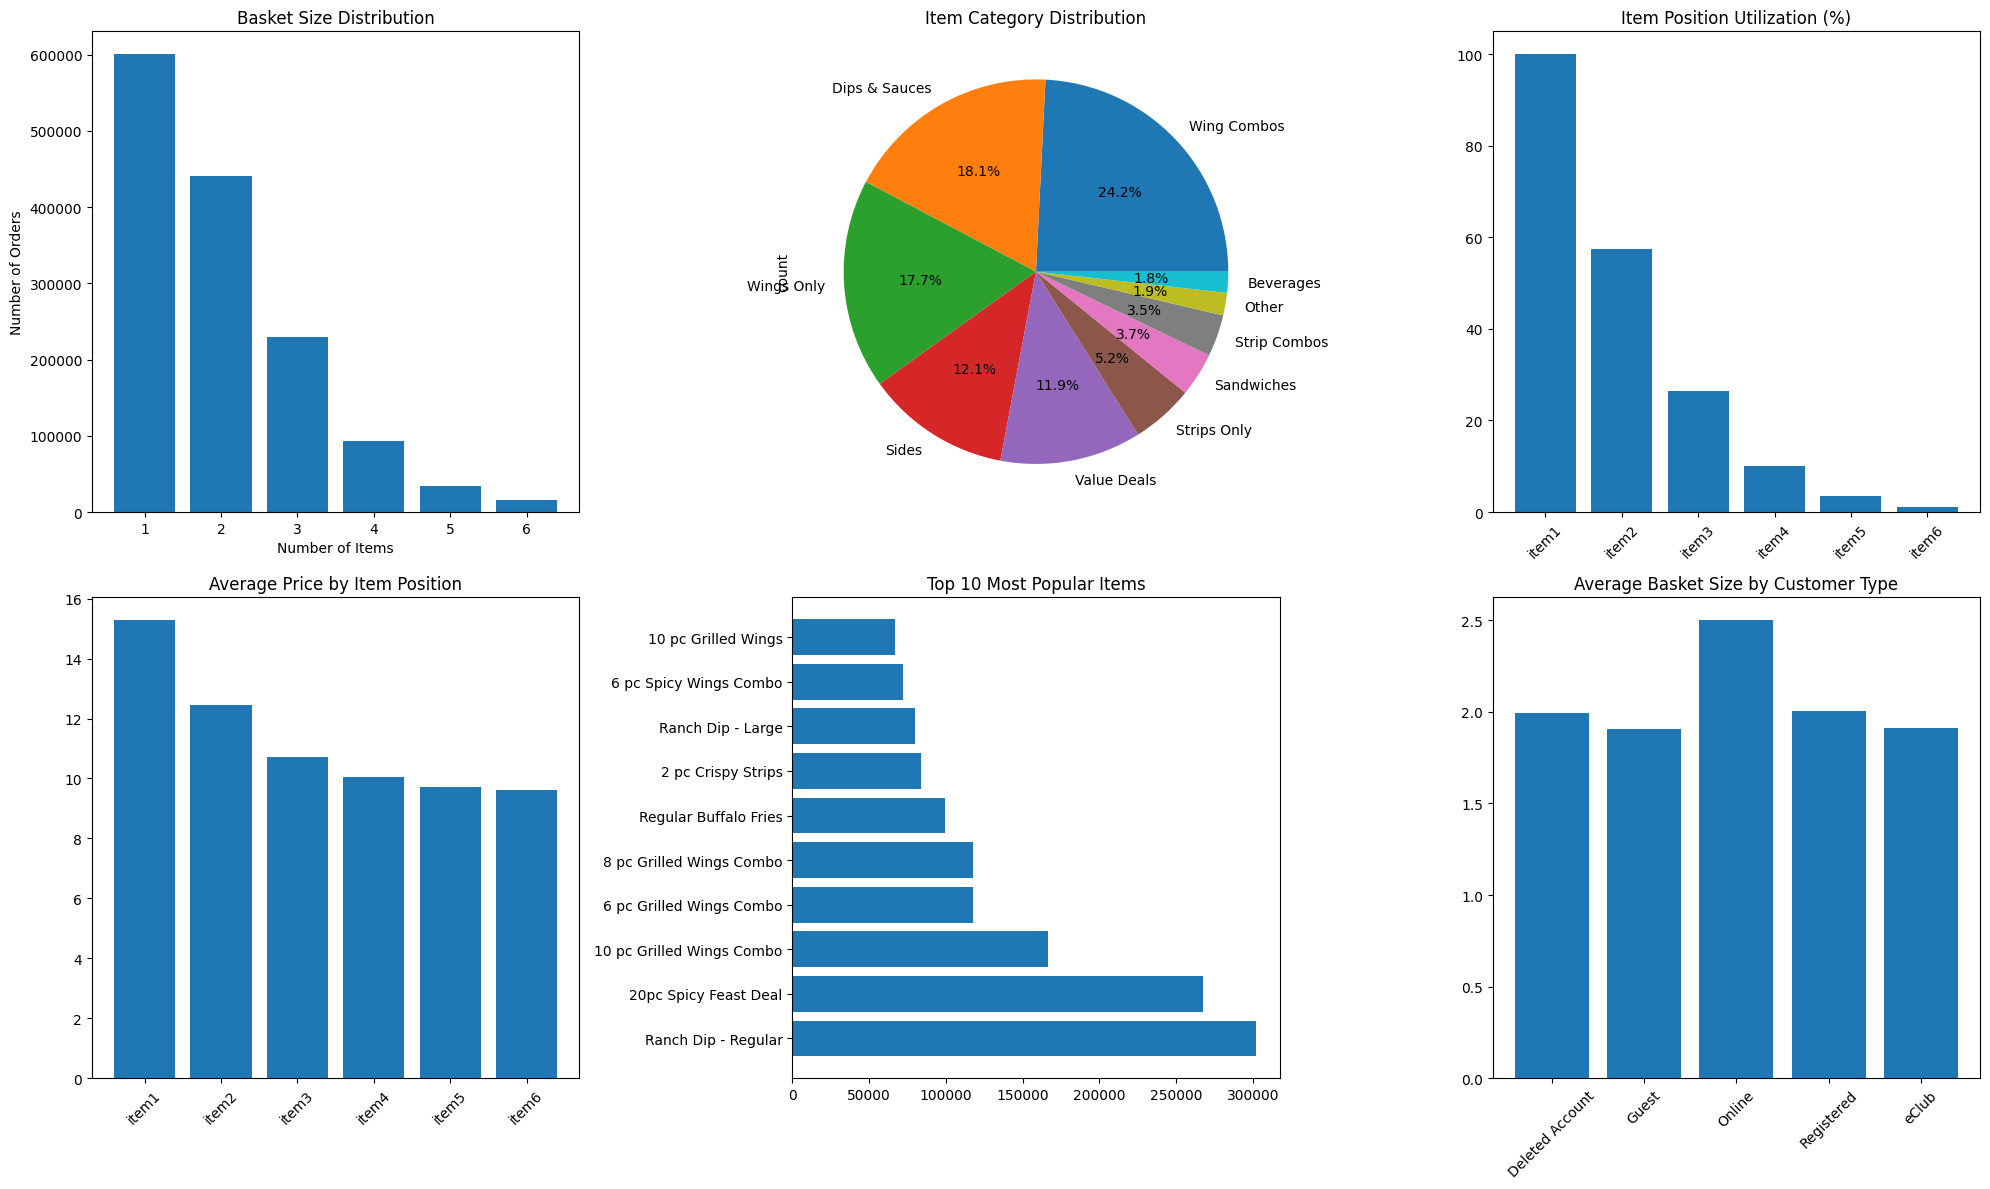

In [91]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Basket size distribution
basket_dist = df_final_clean['basket_size'].value_counts().sort_index()
axes[0, 0].bar(basket_dist.index, basket_dist.values)
axes[0, 0].set_title('Basket Size Distribution')
axes[0, 0].set_xlabel('Number of Items')
axes[0, 0].set_ylabel('Number of Orders')

# 2. Category distribution pie chart
category_analysis.plot(kind='pie', ax=axes[0, 1], autopct='%1.1f%%')
axes[0, 1].set_title('Item Category Distribution')

# 3. Item position utilization
position_utilization = []
for col in item_columns:
    utilization = df_final_clean[col].notna().sum() / len(df_final_clean) * 100
    position_utilization.append(utilization)

axes[0, 2].bar(item_columns, position_utilization)
axes[0, 2].set_title('Item Position Utilization (%)')
axes[0, 2].tick_params(axis='x', rotation=45)

# 4. Average price by position
avg_prices = [position_price_analysis[col]['avg_price'] for col in item_columns if col in position_price_analysis]
positions = [col for col in item_columns if col in position_price_analysis]
axes[1, 0].bar(positions, avg_prices)
axes[1, 0].set_title('Average Price by Item Position')
axes[1, 0].tick_params(axis='x', rotation=45)

# 5. Top 10 overall items
top_items = item_popularity.most_common(10)
items, counts = zip(*top_items)
axes[1, 1].barh(range(len(items)), counts)
axes[1, 1].set_yticks(range(len(items)))
axes[1, 1].set_yticklabels([item[:30] + '...' if len(item) > 30 else item for item in items])
axes[1, 1].set_title('Top 10 Most Popular Items')

# 6. Customer type basket size comparison
customer_basket_sizes = df_final_clean.groupby('CUSTOMER_TYPE')['basket_size'].mean()
axes[1, 2].bar(customer_basket_sizes.index, customer_basket_sizes.values)
axes[1, 2].set_title('Average Basket Size by Customer Type')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [94]:
# Generate insights for recommendation strategy
print("=== KEY INSIGHTS FOR RECOMMENDATION ENGINE ===")

# Most complementary items (appear together frequently)
from itertools import combinations

co_occurrence = Counter()
for _, row in df_final_clean.iterrows():
    items_in_order = [row[col] for col in item_columns if pd.notna(row[col])]
    if len(items_in_order) >= 2:
        for combo in combinations(items_in_order, 2):
            co_occurrence[combo] += 1

print("\nTop 10 Item Pairs (Co-occurrence):")
for pair, count in co_occurrence.most_common(10):
    print(f"  {pair[0]} + {pair[1]}: {count} times")

# Single-item orders with high upsell potential
single_item_analysis = df_final_clean[df_final_clean['basket_size'] == 1]['item1'].value_counts()
print(f"\nTop Single-Item Orders (Upsell Opportunities):")
for item, count in single_item_analysis.head(10).items():
    print(f"  {item}: {count} single-item orders")

# Category gaps (categories rarely combined)
print(f"\nMost Promising Cross-Category Opportunities:")
print("- Wings + Beverages: High potential for drink upsells")
print("- Wings + Dips: Natural flavor enhancement combinations")
print("- Value Deals + Sides: Meal completion opportunities")

=== KEY INSIGHTS FOR RECOMMENDATION ENGINE ===

Top 10 Item Pairs (Co-occurrence):
  10 pc Grilled Wings Combo + Ranch Dip - Regular: 23196 times
  Ranch Dip - Regular + 10 pc Grilled Wings Combo: 22940 times
  Ranch Dip - Regular + Regular Buffalo Fries: 20852 times
  Regular Buffalo Fries + Ranch Dip - Regular: 20737 times
  10 pc Grilled Wings + Ranch Dip - Regular: 19272 times
  Ranch Dip - Regular + 10 pc Grilled Wings: 19162 times
  10 pc Spicy Wings + Ranch Dip - Regular: 15681 times
  Ranch Dip - Regular + 10 pc Spicy Wings: 15532 times
  8 pc Grilled Wings Combo + Ranch Dip - Regular: 15117 times
  Ranch Dip - Regular + 8 pc Grilled Wings Combo: 15071 times

Top Single-Item Orders (Upsell Opportunities):
  20pc Spicy Feast Deal: 141742 single-item orders
  10 pc Grilled Wings Combo: 51921 single-item orders
  6 pc Grilled Wings Combo: 40280 single-item orders
  8 pc Grilled Wings Combo: 39198 single-item orders
  Flavor Platter: 26273 single-item orders
  6 pc Spicy Wings Comb

Universal Dip Upsell Strategy
Your data shows Ranch Dip dominates co-occurrence patterns:

10 out of 10 top pairs include Ranch Dip → Make this your #1 recommendation for wings

20K+ co-occurrences with Buffalo Fries → Suggest Ranch Dip for any sides order
